# Make gas emission cubes
In this tutorial you will see how to use disc2radmc to create all the input files that radmc3d needs to run and how to run radmc3d to produce gas emission cubes. This is very similar to the case of dust. In fact, for the gas model we will have dust and gas.

In [1]:
import numpy as np
import disc2radmc 
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

%matplotlib inline
%config InlineBackend.figure_format='retina'

We start by defining what the surface density of dust and gas will be. These can be the same or different. For simplicity we will use the same. This is defined as a function that receives the cylindrical `r` and `phi` as the first arguments, followed by any argument that defines the surface density. This doesn't need to be normalized as that will be done internally for each dust species. This function must be able to receive ndarray's for r and phi. 

Below an example of a surface density that is a Gaussian radially, but varies azimuthally as sin(phi)

In [2]:
def Sigma_all(r, phi, rc, sigr):
    
    return np.exp( -0.5 * ((r-rc)/sigr)**2.)

We now define the parameters that will define our model. This is the same as the parameters for the dust only model, but with a few additional ones. These are the gas species (atoms, molecules, etc), their masses, stellar mass (which sets the gas velocity), etc. Note that many of these parameters don't need to be defined and they will be set to default values. However, it is better to know how to change these if your model is more complicated.

For gas, you will need to download the cross sections of each gas species that you want to model. These can be found in https://home.strw.leidenuniv.nl/~moldata/, a few of which are in https://github.com/SebaMarino/disc2radmc/tree/main/opacities/gas

In [3]:
########################
###### PARAMETERS ######
########################

## STAR
## STAR
dpc=50.  # [pc] distance to source 
target='HDawesome'# name
Rstar=1.0 # [Solar radii]
Tstar= -5800 # [K] If this is negative, the code will consider the star as a blackbody. 
g=4.0
# For a realistic stellar model, you can download bt-settl models 
# from http://svo2.cab.inta-csic.es/theory/newov2/index.php and indicate their directory below
# dir_stellar_templates='/Users/Sebamarino/Astronomy/Stellar_templates/BT-Settl/bt-settl/'
# The code will then search for files named as 
# dir_stellar_templates+'lte%03i-%1.1f-0.0a+0.0.BT-NextGen.7.dat.txt'%(Tstar//100,g) if Tstar>=2600
# dir_stellar_templates+'lte%03i-%1.1f-0.0.BT-Settl.7.dat.txt'%(T//100,g)            else
# and interpolate models with neighbouring temperatures if necessary

## DUST
Mdust=0.5      # [Mearth] Total dust mass
rc=100.        # [au]
sigr=50.       # [au]
amin=1.0       # [mu]  minimum grain size (1 by default)
amax=1.0e4     # [mu]  maximum grain size (1e4 by default)
N_species=1    #  (1 by default) Number of dust size bins to use for the radiative transfer calculations. 
slope = -3.5   #  (-3.5 by default) Slope of the size distribution. This is used for computing opacities and for the mass distribution of each size bin
h=0.05         # vertical aspect ratio =H/r, where H is the vertical standard deviation. This is a constant, but other parametrizations are possible and will be shown below. 
par_sigma=(rc, sigr) # list containing the parameters that define the dust surface density. They must be in the same order as in the definition of Sigma_dust

## GAS
gas_species=['12c16o', 'catom'] # species. Each one of these must have a file named molecule_*.inp containing its cross sections. These can be downloaded from https://home.strw.leidenuniv.nl/~moldata/
Masses=np.array([1.0e-2, 1.0e-3 ]) # [Mearth] Total mass of each gas species
masses=np.array([28.*disc2radmc.mp, 12*disc2radmc.mp ]) # [g] molecular weight of each species
mu=28. # mean molecular weight. This could be = np.sum(masses*Masses)/np.sum(Msses)/np.disc2radmc.mp
turbulence=True
alpha_turb=1.0e-2

## MODEL SPATIAL GRID
rmin=10. # [au] make sure it is small enough to sample the surface density
rmax=300.# [au] 
Nr=50    # radial cells (linearly or logspaced)
Nphi=50 # azimuthal cells
Nth=50   # polar angle cells (per emisphere)
thmax=np.arctan(h)*10 # maximum polar angle to sample as measured from the midplane.
axisym=False # Consider the disc to be axisymmetric to speed up calculations? it can overwrite Nphi if True and set it to 1
mirror=False  # Mirror the upper half to speed up calculations. This is incompatible with anisotropic scattering. When including radial velocities in the gas, if the model is mirrored the channel maps appear wrong (not sure why).

logr=True # Sample r logarithmically or linearly

# WAVELENGTH GRID (grid to sample the stellar flux in temperature calculations, see radmc3d manual)
lammin=0.09  # [mu]  minimum wavelength to consider in our model (important for temperature calculation)
lammax=1.0e5 # [mu] minimum wavelength to consider in our model (important for temperature calculation)
Nlam=150     # number of cells logarithmically spaced to sample the wavelength range.

# IMAGE PARAMETERS
Npix=512  # number of pixels
dpix=0.03 # pixel size in arcsec
inc=45.    # inclination
PA=90.    # position angle

wavelength=880. # [um] image wavelength
scattering_mode=1 # scattering mode (0=no scattering, 1=isotropic, 2=anisotropic using H&G function)



Our model will be made of multiple objects that we need to define and save for radmc3d: 
- Spatial grid
- Wavelength grid
- Star
- Dust
- Gas

In [4]:
### PHYSICAL GRID
gridmodel=disc2radmc.physical_grid(rmin=rmin, rmax=rmax, Nr=Nr, Nphi=Nphi, Nth=Nth, thmax=thmax, mirror=mirror, logr=logr, axisym=axisym)
gridmodel.save()

### WAVELENGTH GRID
lammodel=disc2radmc.wavelength_grid(lammin=lammin, lammax=lammax, Nlam=Nlam)
lammodel.save()

### STAR
starmodel=disc2radmc.star(lammodel, Tstar=Tstar, Rstar=Rstar, g=g,
                               #dir_stellar_templates=dir_stellar_templates # necessary line if Tstar>0
                               )
starmodel.save()


For the dust, we will mix the optical constants of three species (astrosilicates, amorphous carbon and water ice) using the Bruggeman rule.

In [5]:
### DUST SIZE DISTRIBUTION AND OPACITY
# path to optical constants that can be found at
# https://github.com/SebaMarino/disc2radmc/tree/main/opacities/dust_optical_constants
path_opct='/Users/Sebamarino/Astronomy/Codes/disc2radmc/opacities/dust_optical_constants/' 
lnk_files=[path_opct+'astrosilicate_ext.lnk',
           path_opct+'ac_opct.lnk',
           path_opct+'ice_opct.lnk']
densities=[4., 3., 1.] # densities in g/cm3
mass_weights=[70.0, 15., 15.] # mixing ratios by mass
dust=disc2radmc.dust(lammodel,
                           Mdust=Mdust,
                           lnk_file=lnk_files,
                           densities=densities,
                           N_species=N_species,
                           slope=slope,
                           N_per_bin=100, # number of species per size bin to have a good representation 
                           mass_weights=mass_weights,
                           tag='mix', # name to give to this new mixed species
                           compute_opct=True) 

Compute average optical constants
final density = 2.7 g/cm3


Now we will compute the opacity using the Mie theory by Craig F. Bohren and Donald R. Huffman. For that, you first need to download the files at https://github.com/SebaMarino/disc2radmc/tree/main/opacities/Mie, and compile them by opening a terminal, cd'ing into the folder where you download them and running `make`. That will create an executable file called `makeopac`, which you then need to copy to your working directory. Then you can compute the opacities as `dust.compute_opacities()` which will produce one or a set of files containing the opacities of the N_species dust species. This might take a while, so you probably want to comment that line after computing your final opacities.

In [6]:
dust.compute_opacities()

We now define our dust densities in each cell of the spatial grid and save this for radm3d.

In [7]:
### DUST DENSITY DISTRIBUTION
dust.dust_densities(grid=gridmodel,function_sigma=Sigma_all, par_sigma=par_sigma, h=h)
dust.write_density()

Normally, one would deine the gas before running radmc3d. However, we will include turbulence in our gas model, which is parametrised as a function of the temperature. Similarly, one could define a scale height based on the calculated temperature. 
### So let's run radmc3d to compute the temperature
We start by specifying some parameters for RADMC3D. We proceed computing the temperature with the thermal montecarlo simulation. Then we will compute an image, and finally an SED.

In [8]:
sim=disc2radmc.simulation(nphot=10000000, # number of photon packages for thermal monte carlo
                            nphot_scat=1000000, # number of photon packages for image
                            nphot_spec=10000,   # number of photon packages for spectrum
                            nphot_mono=10000,   # number of photon packages for the monochromatic monte carlo
                            scattering_mode=scattering_mode, 
                            incl_lines=1, # whether to include gas lines (1) or not (0)
                            modified_random_walk=0, # for very optically thick medium, this is a useful approximation
                            istar_sphere=0, # consider the star a sphere or a point.
                            tgas_eq_tdust=1, # gas temperature equal to the temperature of the first dust species
                            setthreads=4,
                            verbose=True, 
                               )

### RUN MCTHERM to compute temperature
sim.mctherm()

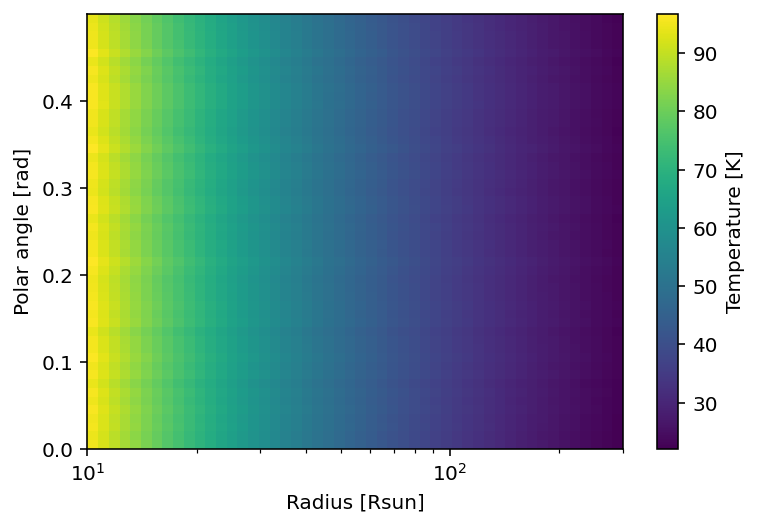

In [9]:
# check temperature (northern emisphere)
Ts=np.fromfile('./dust_temperature.bdat', count=gridmodel.Nr*gridmodel.Nphi*gridmodel.Nth+4, dtype=float)[4:].reshape( (gridmodel.Nphi, gridmodel.Nth, gridmodel.Nr))
plt.pcolormesh(gridmodel.redge, gridmodel.thedge[::-1], Ts[0,:gridmodel.Nth,:])
plt.xlabel('Radius [Rsun]')
plt.xscale('log')
plt.ylabel(r'Polar angle [rad]')
plt.colorbar(label='Temperature [K]')
plt.show()

# Let's define the gas now that we have the temperature

In [10]:
gas=disc2radmc.gas(gas_species=gas_species,
                         star=starmodel,
                         grid=gridmodel,
                         functions_sigma=[Sigma_all, Sigma_all], # surface density function for each gas species
                         pars_sigma=[par_sigma, par_sigma], # parameters for each gas species
                         Masses=Masses, # Total gas mass of each species
                         masses=masses, # molecular weights
                         h=h, # vertical aspect ratio
                         mu=mu, # mean molecular weight
                         turbulence=turbulence,
                         alpha_turb=alpha_turb,
                        )
gas.write_density()
gas.write_velocity()
gas.write_turbulence()

We can first make an image of 12CO 2-1 with `sim.simcube()`. For that we need to indicate which gas species we want (1=CO and 2=CI in this case) and the transition we are interested in. `sim.simcube()` allows to add background sources, fix the stellar flux and pad the final image as it was shown in the example for the dust (https://github.com/SebaMarino/disc2radmc/blob/main/docs/examples/Dust_model.ipynb)

### Note that the gas is assumed to be in LTE. Non-LTE is possible in RADMC3D, but it assumes optically thin emission

In [11]:
sim.simcube(dpc=dpc,
            imagename='12c16o', # name that the image will have
            mol=1,  # indicate which gas species
            line=2, # indicate which transition
            vmax=8, # maximum velocity in km/s
            Nnu=9,# number of channels
            Npix=Npix,
            dpix=dpix,
            inc=inc,
            PA=PA,
            tag=target,
            continuum_subtraction=True # whether you want to subtract the continuum estimated using the first and last channel.
           )

image size = 7.7e+02 au
radmc3d image incl 45.00000  phi  0.00000 posang 0.00000 iline 2 imolspec 1 widthkms 8.00000  vkms 0.0 linenlam 9 npix 512  sizeau 768.00000  doppcatch noscat


Let's see the resulting cube

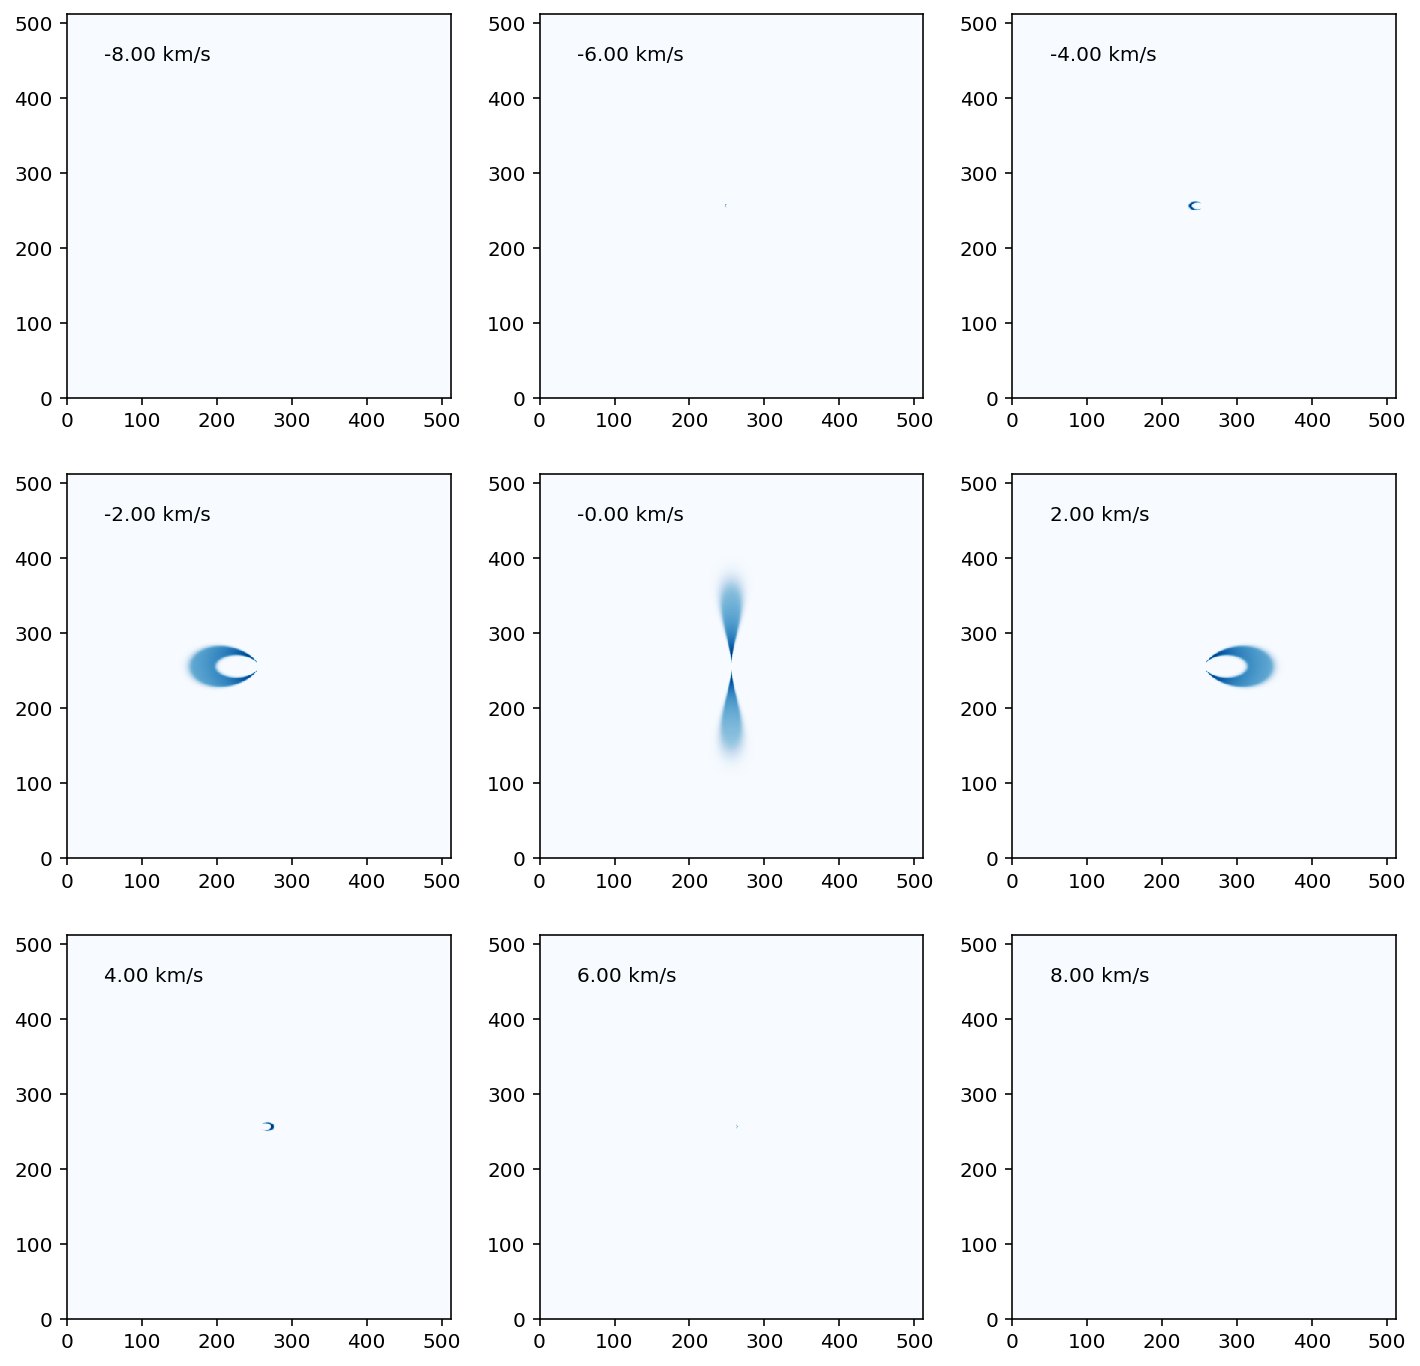

In [12]:
fit1=pyfits.open('./images/image_12c16o_'+target+'.fits')
cube=fit1[0].data[0,:,:,:]
header1= fit1[0].header

Nchan=np.shape(cube)[0]

# let's calculate the velocities of each channel
ckms=299792.458 # km/s
f_line=230.538000 # GHz
df=float(header1['CDELT3'])/1.0e9 # GHz
k0=float(header1['CRPIX3'])
f0=float(header1['CRVAL3'])/1.0e9 - (k0-1)*df # GHz
fs=np.linspace(f0,f0+df*(Nchan-1),Nchan) #GHz
vs=-(fs-f_line)*ckms/f_line  # km/s

channels_plot=np.arange(9)
Nchan=len(channels_plot)
fig=plt.figure(figsize=(12,12))
for ichan in range(Nchan):
    axi=fig.add_subplot(331+ichan)
    axi.pcolormesh(cube[channels_plot[ichan],:,:], vmin=0., vmax=np.max(cube), cmap='Blues')
    axi.set_aspect('equal')
    axi.text(50,450, '%1.2f km/s'%vs[channels_plot[ichan]], color='black' )

Finally, you can define more exotic vertical distributions. First let's change the aspect ratio $h$ as a function of $r$ such that
$$ H(r) = h r_0 (r/r_0)^{\gamma}$$
We will also make the disc more inclined to see the effect

In [13]:
# vertical parameters
h=0.05
r0=rc # reference radius
gamma=3.

gas=disc2radmc.gas(gas_species=gas_species,
                         star=starmodel,
                         grid=gridmodel,
                         functions_sigma=[Sigma_all, Sigma_all], # surface density function for each gas species
                         pars_sigma=[par_sigma, par_sigma], # parameters for each gas species
                         Masses=Masses, # Total gas mass of each species
                         masses=masses, # molecular weights
                         h=h, # vertical aspect ratio
                         r0=r0,
                         gamma=gamma,
                         mu=mu, # mean molecular weight
                         turbulence=turbulence,
                         alpha_turb=alpha_turb,
                        )
gas.write_density()
gas.write_velocity()
gas.write_turbulence()


image size = 7.7e+02 au
radmc3d image incl 90.00000  phi  0.00000 posang 0.00000 iline 2 imolspec 1 widthkms 8.00000  vkms 0.0 linenlam 9 npix 512  sizeau 768.00000  doppcatch noscat


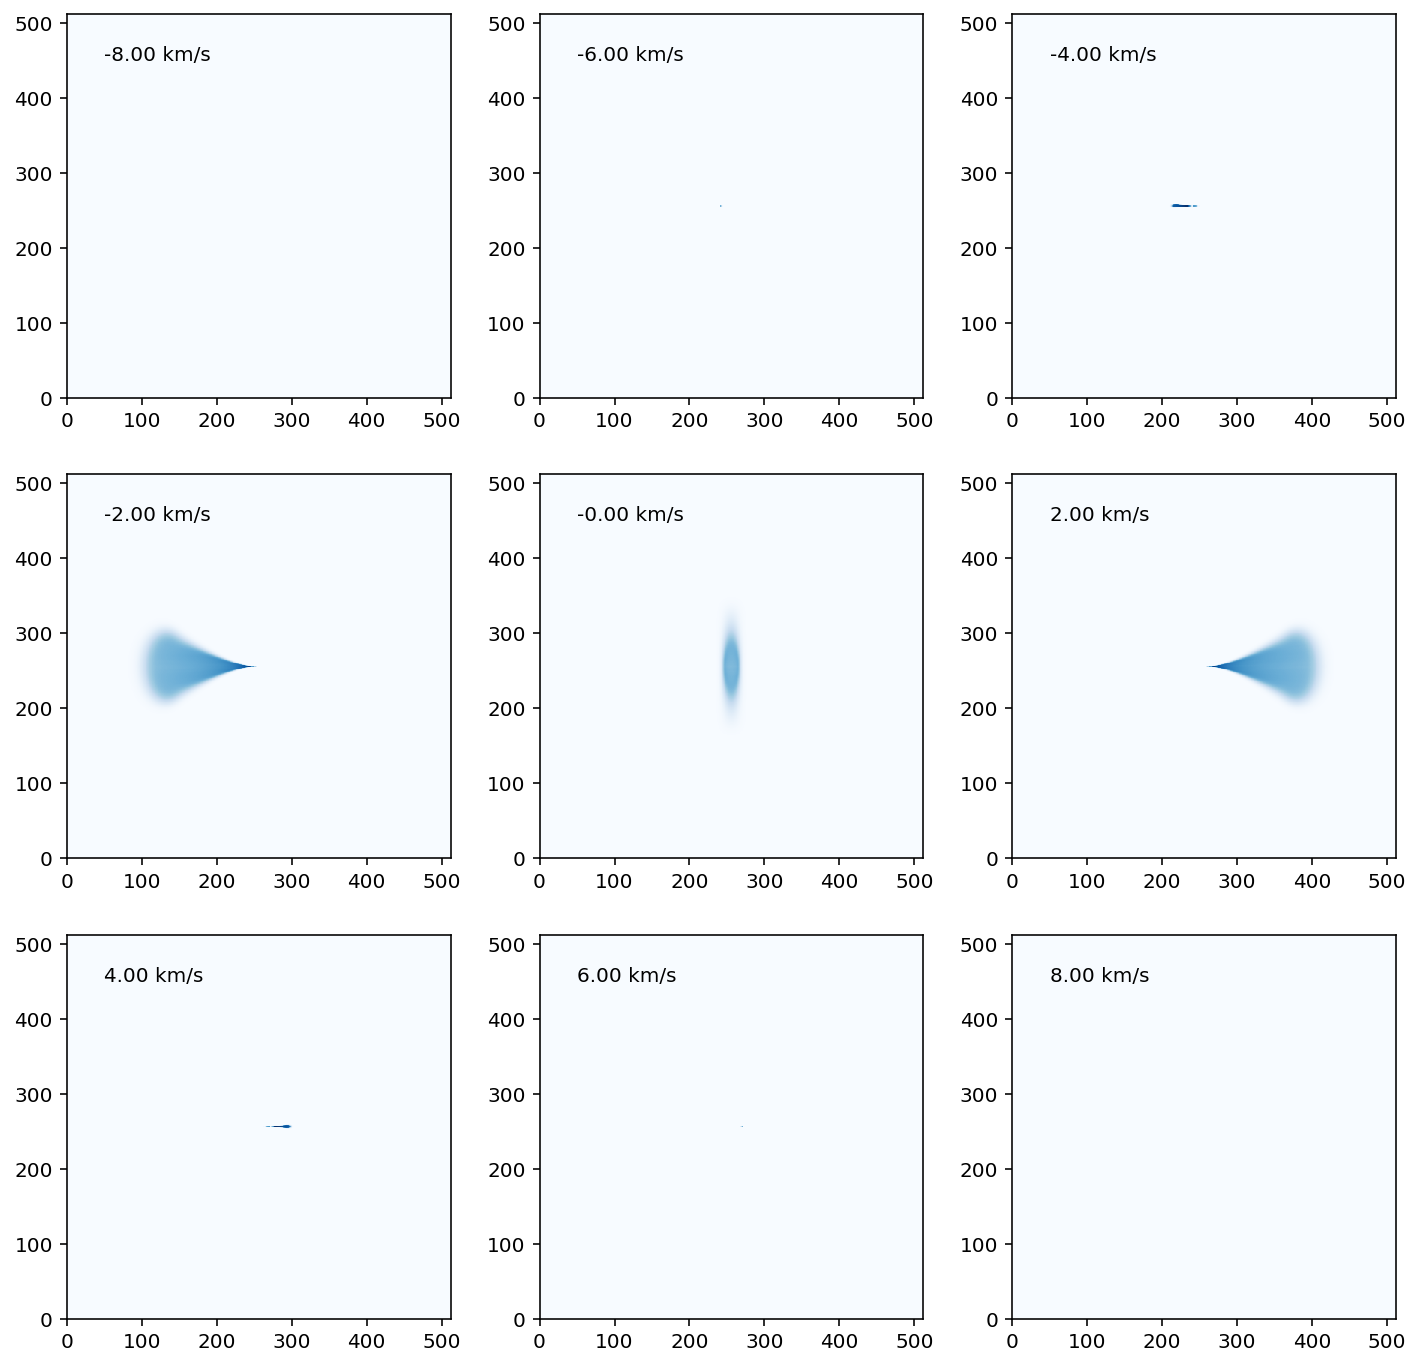

In [14]:
### MAKE CUBE WITH HIGHER INCLINATION
sim.simcube(dpc=dpc,
            imagename='12c16o_2', # name that the image will have
            mol=1,  # indicate which gas species
            line=2, # indicate which transition
            vmax=8, # maximum velocity in km/s
            Nnu=9,# number of channels
            Npix=Npix,
            dpix=dpix,
            inc=90.,
            PA=PA,
            tag=target,
            continuum_subtraction=True # whether you want to subtract the continuum estimated using the first and last channel.
           )

fit1=pyfits.open('./images/image_12c16o_2_'+target+'.fits')
cube=fit1[0].data[0,:,:,:]
header1	= fit1[0].header

Nchan=np.shape(cube)[0]

# let's calculate the velocities of each channel
ckms=299792.458 # km/s
f_line=230.538000 # GHz
df=float(header1['CDELT3'])/1.0e9 # GHz
k0=float(header1['CRPIX3'])
f0=float(header1['CRVAL3'])/1.0e9 - (k0-1)*df # GHz
fs=np.linspace(f0,f0+df*(Nchan-1),Nchan) #GHz
vs=-(fs-f_line)*ckms/f_line  # km/s

channels_plot=np.arange(9)
Nchan=len(channels_plot)
fig=plt.figure(figsize=(12,12))
for ichan in range(Nchan):
    axi=fig.add_subplot(331+ichan)
    axi.pcolormesh(cube[channels_plot[ichan],:,:], vmin=0., vmax=np.max(cube), cmap='Blues')
    axi.set_aspect('equal')
    axi.text(50,450, '%1.2f km/s'%vs[channels_plot[ichan]], color='black' )


We can even define functions for the vertical distribution that are different from a Gaussian, as long as they are correctly normalized and can be defined as a function of z and H. Note that in this case H is simply a reference height and it can be a constant or vary with r by changing `gamma`. The vertical distribution function (called `rhoz_exotic` below), needs to be in units of 1/au and normalized such that $\int_{-\infty}^{\infty} \rho_{z, \mathrm{exotic}}(z)dz =1$. This is because the actual density is defined as the product between the surface density and the vertical distribution function (here called rhoz_exotic).


image size = 7.7e+02 au
radmc3d image incl 90.00000  phi  0.00000 posang 0.00000 iline 2 imolspec 1 widthkms 8.00000  vkms 0.0 linenlam 9 npix 512  sizeau 768.00000  doppcatch noscat


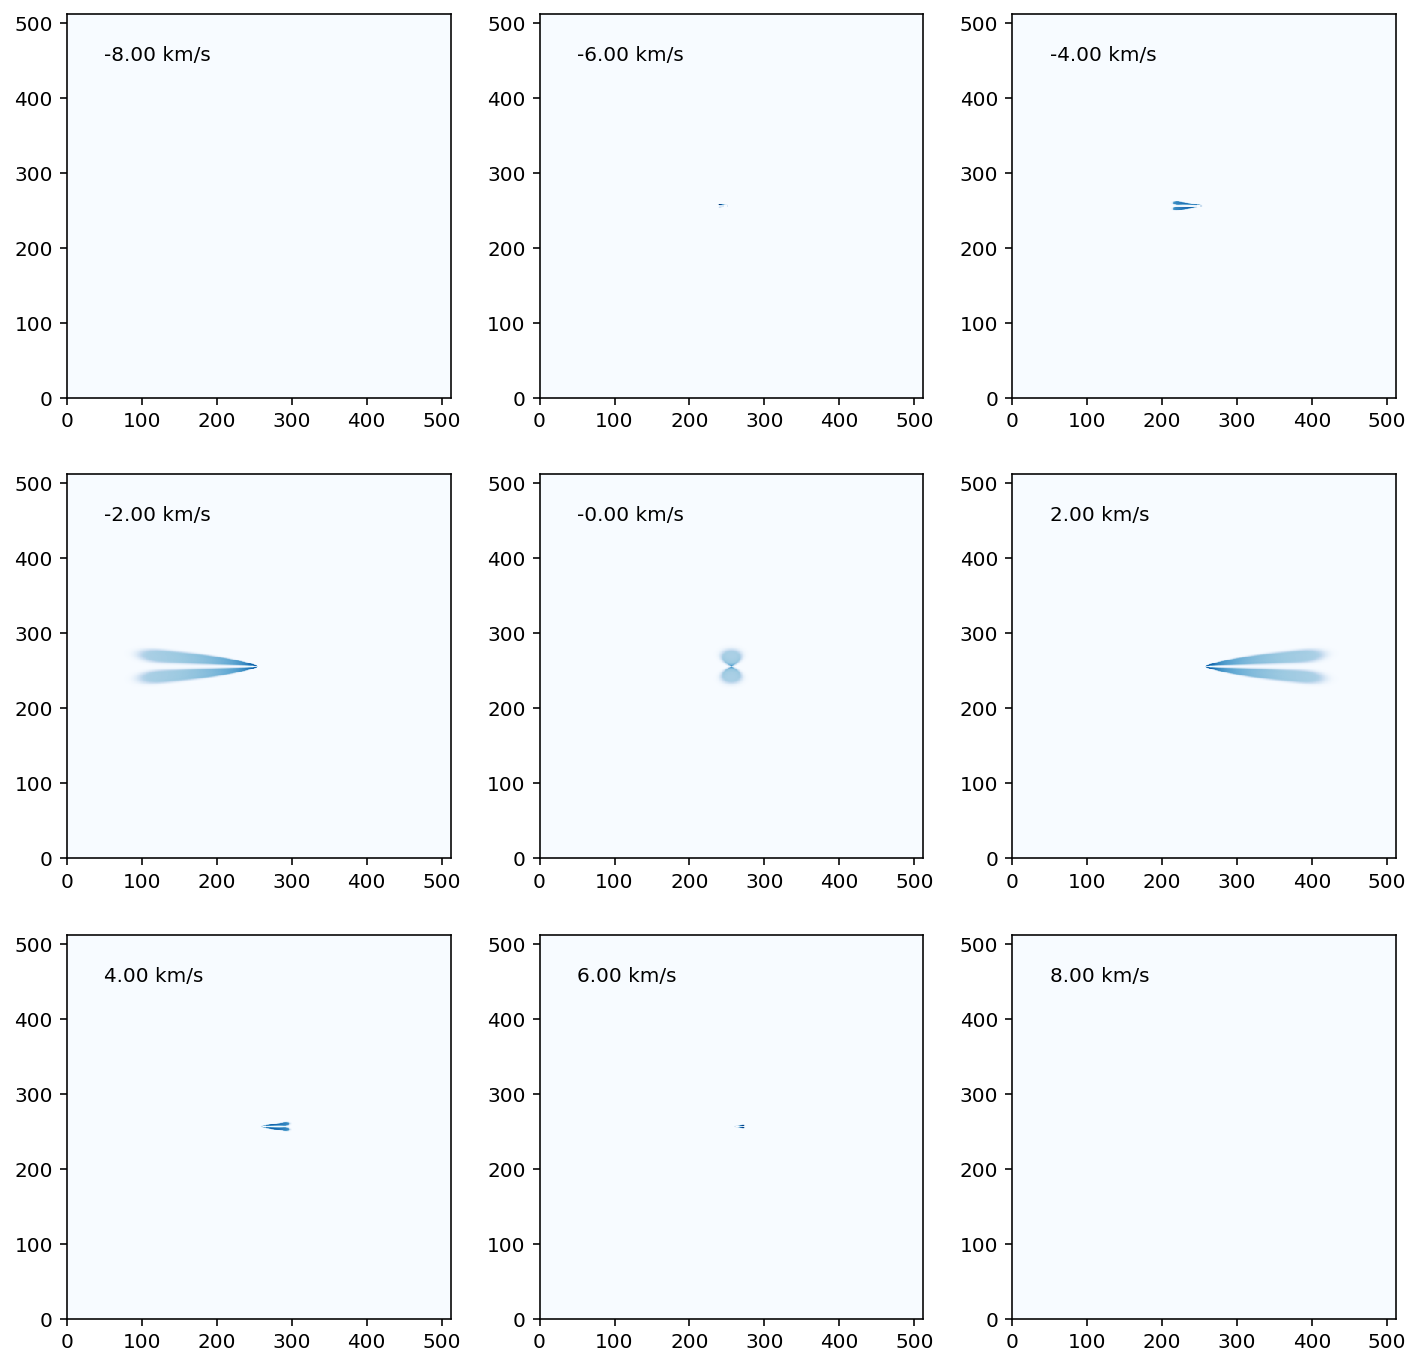

In [15]:
def rhoz_exotic(z, H):
    return 0.5*( np.exp(-(z-2*H)**2.0/(2.0*(H/2)**2.0))/(np.sqrt(2.0*np.pi)*H/2)+np.exp(-(z+2*H)**2.0/(2.0*(H/2)**2.0))/(np.sqrt(2.0*np.pi)*H/2) )

# vertical parameters
h=0.05
r0=rc # reference radius
gamma=1.

gas=disc2radmc.gas(gas_species=gas_species,
                         star=starmodel,
                         grid=gridmodel,
                         functions_sigma=[Sigma_all, Sigma_all], # surface density function for each gas species
                         pars_sigma=[par_sigma, par_sigma], # parameters for each gas species
                         Masses=Masses, # Total gas mass of each species
                         masses=masses, # molecular weights
                         h=h, # vertical aspect ratio
                         r0=r0,
                         gamma=gamma,
                         mu=mu, # mean molecular weight
                         turbulence=turbulence,
                         alpha_turb=alpha_turb,
                         functions_rhoz=[rhoz_exotic,rhoz_exotic], # one for each gas species
                        )
gas.write_density()
gas.write_velocity()
gas.write_turbulence()
sim.simcube(dpc=dpc,
            imagename='12c16o_3', # name that the image will have
            mol=1,  # indicate which gas species
            line=2, # indicate which transition
            vmax=8, # maximum velocity in km/s
            Nnu=9,# number of channels
            Npix=Npix,
            dpix=dpix,
            inc=90.,
            PA=PA,
            tag=target,
            continuum_subtraction=True # whether you want to subtract the continuum estimated using the first and last channel.
           )

fit1=pyfits.open('./images/image_12c16o_3_'+target+'.fits')
cube=fit1[0].data[0,:,:,:]
header1	= fit1[0].header

Nchan=np.shape(cube)[0]

# let's calculate the velocities of each channel
ckms=299792.458 # km/s
f_line=230.538000 # GHz
df=float(header1['CDELT3'])/1.0e9 # GHz
k0=float(header1['CRPIX3'])
f0=float(header1['CRVAL3'])/1.0e9 - (k0-1)*df # GHz
fs=np.linspace(f0,f0+df*(Nchan-1),Nchan) #GHz
vs=-(fs-f_line)*ckms/f_line  # km/s

channels_plot=np.arange(9)
Nchan=len(channels_plot)
fig=plt.figure(figsize=(12,12))
for ichan in range(Nchan):
    axi=fig.add_subplot(331+ichan)
    axi.pcolormesh(cube[channels_plot[ichan],:,:], vmin=0., vmax=np.max(cube), cmap='Blues')
    axi.set_aspect('equal')
    axi.text(50,450, '%1.2f km/s'%vs[channels_plot[ichan]], color='black' )
